In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool

mi.set_variant('cuda_ad_rgb')

In [2]:
# !python3 /home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/generate_cbox.py 3


In [3]:
scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox-area.xml")

In [4]:
from emitter_sampling import RadianceCacheEM
from radiosity_sh import SceneSurfaceSampler

scene_sampler = SceneSurfaceSampler(scene)
radiance_cache_exact = RadianceCacheEM(scene, 256, 128)

Fitting spherical harmonics to scene...


100%|██████████| 8/8 [00:00<00:00,  8.15it/s]

Fitting complete.


In [5]:
colors = {
    'white': [0.9, 0.7, 0.6],
    'box': [0.5, 0.3, 0.9],
    'red': [0.6, 0.1, 0.1],
    'green': [0.1, 0.4, 0.1],
    'light': [0.9, 0.7, 0.7]
}

mesh_materials = ['white', 'white', 'white', 'green', 'red', 'box', 'box', 'light']

In [6]:
from vertex_bsdf import Diffuse

bsdf_train = Diffuse()

for mesh_idx, (mesh, material) in enumerate(zip(scene.shapes(), mesh_materials)):
    if not(mesh.is_mesh()):
        continue
    bsdf_train.initialize_mesh_attributes(mesh, [0.5, 0.5, 0.5])
    # bsdf_train.initialize_mesh_attributes(mesh, colors[material])

In [9]:
from bsdf_utils import render_base_color, ps_visualize_textures
import matplotlib.pyplot as plt
import numpy as np

# ps_visualize_textures(scene)

out = render_base_color(scene, (512, 512), False)
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(out); plt.tight_layout()

In [10]:
NUM_GEO_SAMPLES = 1 << 10 # 1 << 14
NUM_WI_DIRECTIONS = 256 << 0

In [11]:
from emitter_sampling import compute_loss
from time import time

params = mi.traverse(scene)
keys = [key for key in params.keys() if "vertex_bsdf_base_color" in key]
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

losses = []
for it in range(250):
    if it % 50 == 0:
        render_base_color(scene, (512, 512), True, f"output/itr={it}")

    time1 = time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache_exact, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, num_wo = 8, rng_state = it)
    
    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [5.694295]: Loss = [0.00074289]
Iteration 002 [0.365335]: Loss = [0.000558573]
Iteration 003 [0.364012]: Loss = [0.00040717]
Iteration 004 [0.348999]: Loss = [0.000299372]
Iteration 005 [0.349641]: Loss = [0.000195889]
Iteration 006 [0.352592]: Loss = [0.000145316]
Iteration 007 [0.349473]: Loss = [8.1199e-05]
Iteration 008 [0.351937]: Loss = [4.72453e-05]
Iteration 009 [0.351047]: Loss = [2.47763e-05]
Iteration 010 [0.350632]: Loss = [1.73431e-05]
Iteration 011 [0.350606]: Loss = [2.24996e-05]
Iteration 012 [0.349525]: Loss = [3.09672e-05]
Iteration 013 [0.350707]: Loss = [4.48653e-05]
Iteration 014 [0.352756]: Loss = [5.74487e-05]
Iteration 015 [0.352202]: Loss = [5.86546e-05]
Iteration 016 [0.351363]: Loss = [5.75072e-05]
Iteration 017 [0.351343]: Loss = [5.92829e-05]
Iteration 018 [0.349904]: Loss = [5.83005e-05]
Iteration 019 [0.355474]: Loss = [6.17431e-05]
Iteration 020 [0.352123]: Loss = [5.19923e-05]
Iteration 021 [0.354156]: Loss = [4.7397e-05]
Iteration 022 [0.

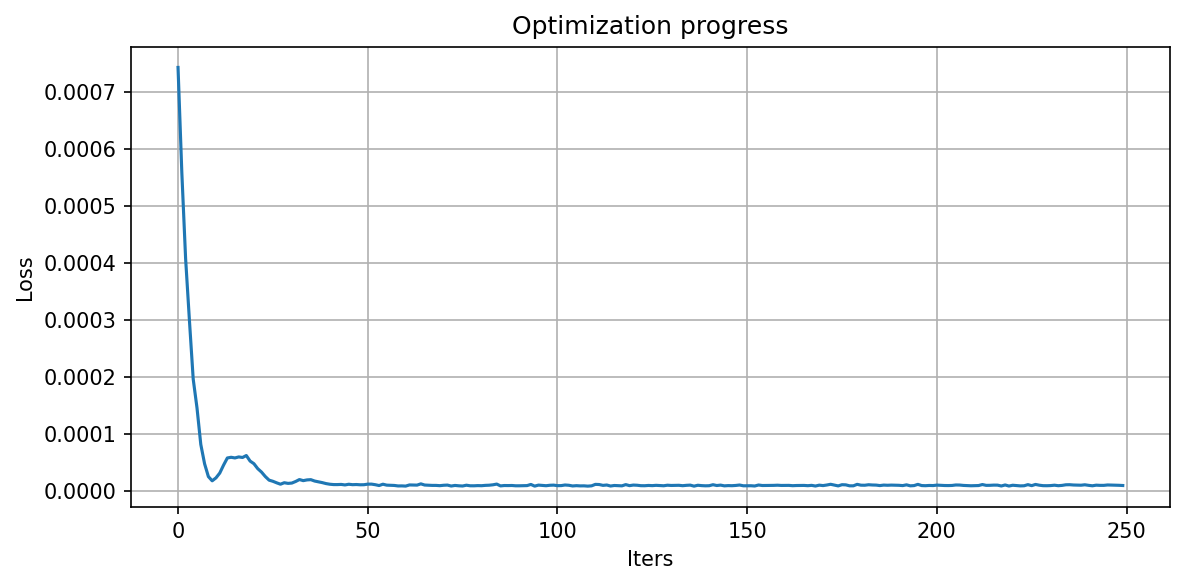

In [12]:
plt.figure(figsize=(8,4), dpi=150)
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.savefig("./output/loss.png")

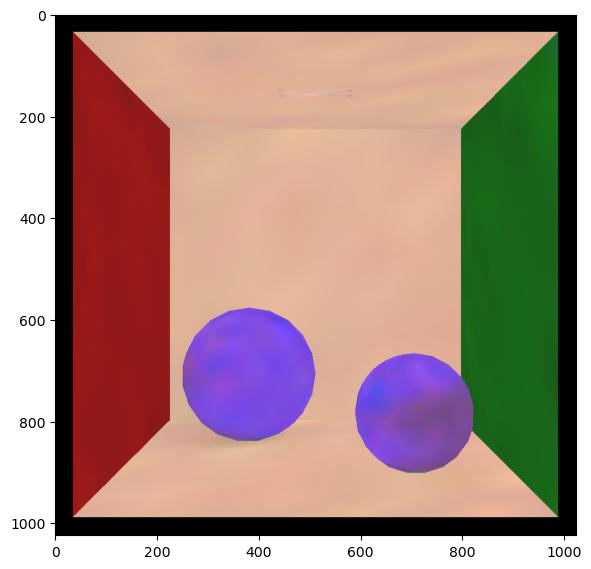

In [13]:
out = render_base_color(scene, (512, 512), True, "output/final")

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(out)
plt.tight_layout()

In [14]:
from bsdf_utils import ps_visualize_textures

ps_visualize_textures(scene)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.120
